In [1]:
%pylab inline
%autosave 25

import joblib
import pickle
import umap
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from xgboost import XGBClassifier

from sklearn.metrics import f1_score

Populating the interactive namespace from numpy and matplotlib


Autosaving every 25 seconds


## Get some data

In [2]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

In [27]:
df_features = pd.read_csv('../data/overfitting_badness_v0.csv', index_col=0)

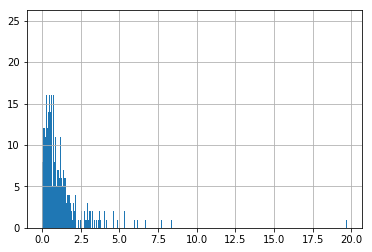

In [33]:
df_features['overfitting_badness_magnitude'].hist(bins=1000)

In [24]:
df_features = pd.read_csv(data_loc+'drug_features/reduced_fingerprints_v1.5.csv', index_col=0)

In [25]:
df_features['2070_2380_76'].head()

cid
38258       0
23644997    0
76314488    0
46225960    0
3005573     0
Name: 2070_2380_76, dtype: int64

In [26]:
df_features = pd.read_csv('../runner/data/drug_features/fingerprints.csv', index_col=0)
df_features['2070_2380_76'].head()

cid
38258       0
23644997    0
76314488    0
46225960    0
3005573     0
Name: 2070_2380_76, dtype: int64

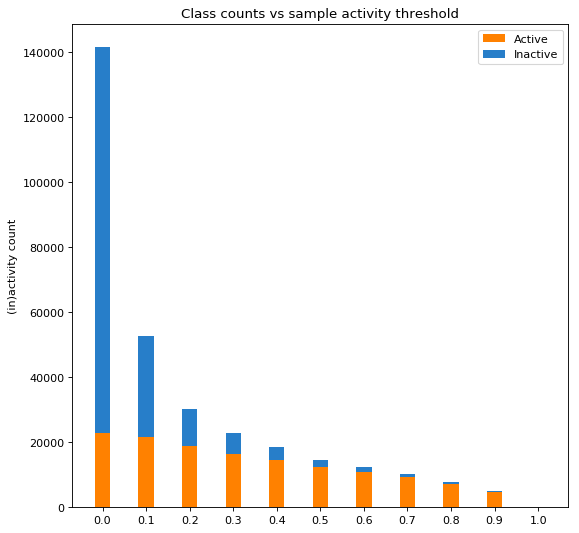

[22890, 21530, 18696, 16477, 14497, 12399, 10910, 9219, 7233, 4750, 0]
[118712, 31007, 11547, 6254, 3897, 2126, 1508, 904, 505, 105, 0]


In [6]:
df_features = pd.read_csv('../data/training_validation_split/training_interactions_v3.csv', index_col=0)

num_actives = []
num_inactives = []
rng = arange(0, 1.1, 0.1)

for x in rng:
    df_features_sampled = df_features[df_features['activity_score'] > x]
    
    num_active = len(df_features_sampled[df_features_sampled['activity'] == 1.0])
    num_inactive = len(df_features_sampled[df_features_sampled['activity'] == 0.0])
    num_actives.append(num_active)
    num_inactives.append(num_inactive)
    
    del df_features_sampled

plt.figure(figsize=(8, 8), dpi=80)
width = 0.35
p1 = plt.bar(arange(11), num_actives, width, color = '#FF8100')
p2 = plt.bar(arange(11), num_inactives, width, bottom=num_actives, color = '#277ec9')

plt.ylabel('(in)activity count')
plt.title('Class counts vs sample activity threshold')
plt.xticks(arange(11), [str(round(x, 2)) for x in rng])
plt.legend((p1[0], p2[0]), ('Active', 'Inactive'))

plt.show()

print(num_actives)
print(num_inactives)

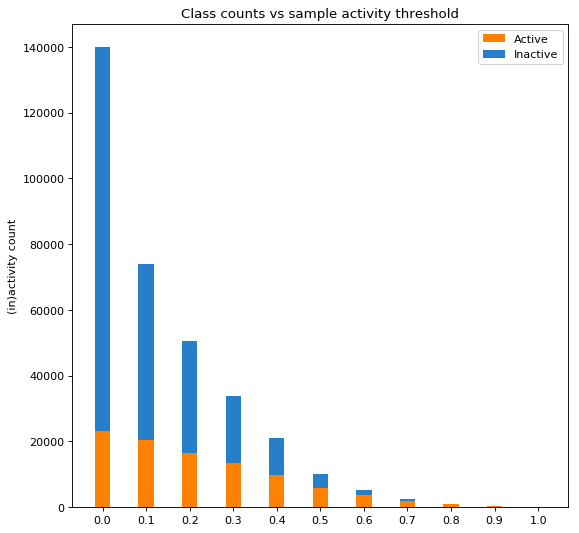

In [91]:
df_features = pd.read_csv('../data/training_validation_split/training_interactions_v2.csv', index_col=0)

num_actives = []
num_inactives = []
rng = arange(0, 1.1, 0.1)

for x in rng:
    df_features_sampled = df_features[df_features['sample_activity_score'] > x]
    
    num_active = len(df_features_sampled[df_features_sampled['activity'] == 1.0])
    num_inactive = len(df_features_sampled[df_features_sampled['activity'] == 0.0])
    num_actives.append(num_active)
    num_inactives.append(num_inactive)
    
    del df_features_sampled

plt.figure(figsize=(8, 8), dpi=80)
width = 0.35
p1 = plt.bar(arange(11), num_actives, width, color = '#FF8100')
p2 = plt.bar(arange(11), num_inactives, width, bottom=num_actives, color = '#277ec9')

plt.ylabel('(in)activity count')
plt.title('Class counts vs sample activity threshold')
plt.xticks(arange(11), [str(round(x, 2)) for x in rng])
plt.legend((p1[0], p2[0]), ('Active', 'Inactive'))

plt.show()

In [14]:
data_loc = '../data/FDA-COVID19_files_v1.0/'

# interactions
df = pd.read_csv(data_loc+'interactions.csv', index_col=0)
df.rename(columns={"canonical_cid": "cid"}, inplace=True)
df['cid'] = df['cid'].astype('str')
print('Number of interaction rows: {:,}'.format(len(df)))
print('Number of interaction columns: {:,}\n'.format(len(df.columns)))

# FDA cids
df_fda = pd.read_csv(data_loc+'fda_drug_cids.csv', index_col=0)
df_fda['cid'] = df_fda['cid'].astype('str')
df_fda['fda'] = 1
print('Number of FDA rows: {:,}'.format(len(df_fda)))
print('Number of FDA columns: {:,}\n'.format(len(df_fda.columns)))

# join
df_merge = pd.merge(df, df_fda, how='outer', on='cid')
df_merge.fillna(0, inplace=True)
df_merge = df_merge[df_merge['pid'] != 0]
print('Number of FDA/interaction rows: {:,}'.format(len(df_merge)))
print('Number of FDA/interaction columns: {:,}\n'.format(len(df_merge.columns)))

# counts
df_sum = df_merge.groupby(['pid']).sum()
g = df_merge.groupby(['pid'])
fda_active = g.apply(lambda x: x[(x['activity'] == 1.0) & (x['fda'] == 1.0)]['activity'].count())
fda_inactive = g.apply(lambda x: x[(x['activity'] == 0.0) & (x['fda'] == 1.0)]['activity'].count())
active = g.apply(lambda x: x[x['activity'] == 1.0]['activity'].count())
inactive = g.apply(lambda x: x[x['activity'] == 0.0]['activity'].count())

fda_active.name = 'fda_active'
fda_inactive.name = 'fda_inactive'
active.name = 'active'
inactive.name = 'inactive'

df_counts = pd.concat([fda_active, fda_inactive, active, inactive], axis=1)
print(df_counts.head(), '\n')

# join counts to interactions
df_coords = pd.merge(df, df_counts, how='inner', on='pid')
print('Number of ineraction+counts rows: {:,}\n'.format(len(df_merge)))
print(df_coords.head())

# scale and umap embedding
X = MinMaxScaler().fit_transform(df_coords.drop(['cid', 'pid'], axis=1))
reducer = umap.UMAP(spread=0.5, min_dist=0.03)
embedding_sampled = reducer.fit_transform(X)

# plot
colors = [sns.color_palette()[1] if x >= 1.0 else sns.color_palette()[0] for x in df_coords.fda_active.values]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
plt.title('FDA vs non-FDA interactions', fontsize=18);
ax = plt.gca()
ax.set_facecolor((0.0, 0.0, 0.0))

Number of interaction rows: 189,312
Number of interaction columns: 3

Number of FDA rows: 3,269
Number of FDA columns: 2

Number of FDA/interaction rows: 189,312
Number of FDA/interaction columns: 4

        fda_active  fda_inactive  active  inactive
pid                                               
10GS_A           1             0       1         3
1A2C_H           1             1       1        91
1A30_A           1             0       1         6
1A42_A           4             0       4        60
1A4G_A           1             0       1         1 

Number of ineraction+counts rows: 189,312

     cid       pid  activity  fda_active  fda_inactive  active  inactive
0  38258  CAA96025         0          20           492      86       550
1    204  CAA96025         1          20           492      86       550
2   8549  CAA96025         0          20           492      86       550
3   3001  CAA96025         0          20           492      86       550
4   2910  CAA96025         0     

In [27]:
# scale and umap embedding
df_coords.drop(['cid', 'pid'], axis=1, inplace=True)
X = MinMaxScaler().fit_transform(df_coords)

In [37]:
reducer = umap.UMAP(min_dist=0.0, n_neighbors=50)
embedding_sampled = reducer.fit_transform(X)

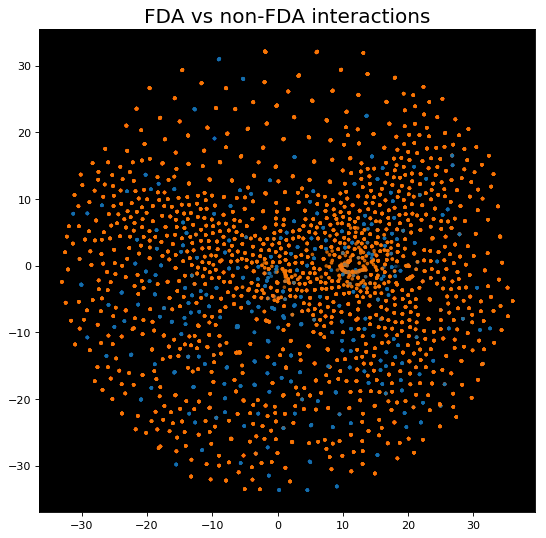

In [38]:
colors = [sns.color_palette()[1] if x >= 1.0 else sns.color_palette()[0] for x in df_coords.fda_active.values]

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
plt.title('FDA vs non-FDA interactions', fontsize=18);
ax = plt.gca()
ax.set_facecolor((0.0, 0.0, 0.0))

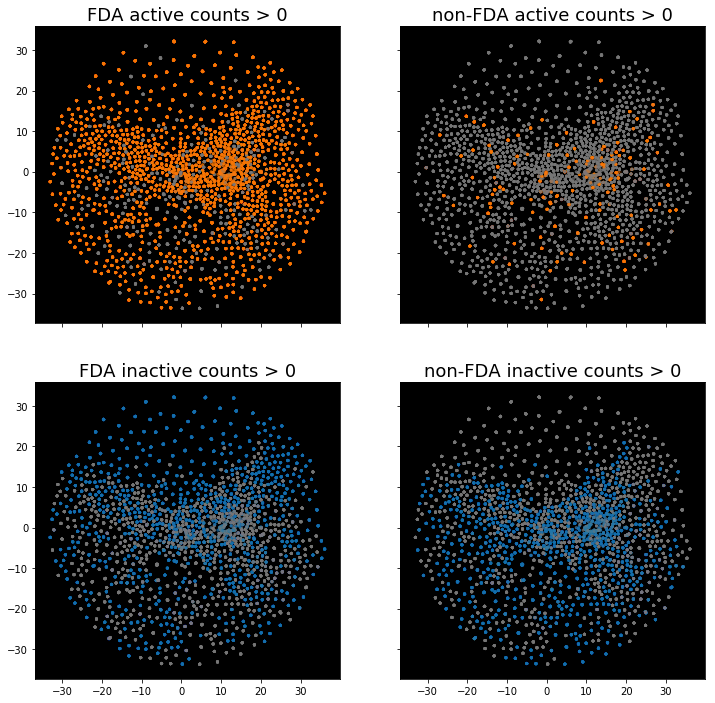

In [39]:
# plot
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row' ,figsize=(12, 12))

colors = [sns.color_palette()[1] if x >= 1.0 else sns.color_palette()[7] for x in df_coords.fda_active.values]

ax[0, 0].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[0, 0].set_title('FDA active counts > 0', fontsize=18);
ax[0, 0].set_facecolor((0.0, 0.0, 0.0))


colors = [sns.color_palette()[1] if x[1] == 0.0 and x[3] >= 1.0 else sns.color_palette()[7] for x in df_coords.values]

ax[0, 1].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[0, 1].set_title('non-FDA active counts > 0', fontsize=18);
ax[0, 1].set_facecolor((0.0, 0.0, 0.0))


colors = [sns.color_palette()[0] if x[2] >= 1.0 else sns.color_palette()[7] for x in df_coords.values]

ax[1, 0].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[1, 0].set_title('FDA inactive counts > 0', fontsize=18);
ax[1, 0].set_facecolor((0.0, 0.0, 0.0))


colors = [sns.color_palette()[0] if x[2] == 0.0 and x[4] >= 1.0 else sns.color_palette()[7] for x in df_coords.values]

ax[1, 1].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[1, 1].set_title('non-FDA inactive counts > 0', fontsize=18);
ax[1, 1].set_facecolor((0.0, 0.0, 0.0))

#### plot pid activity sum across Fda active, fda inactive, non-fda active, non-fda inactive

In [27]:
df = pd.read_csv(data_loc+'interactions.csv', index_col=0)
df.rename(columns={"canonical_cid": "cid"}, inplace=True)
df['cid'] = df['cid'].astype('str')
print('Number of rows: {:,}'.format(len(df)))
print('Number of columns: {:,}\n'.format(len(df.columns)))
df.head()

Number of rows: 189,312
Number of columns: 3



,cid,pid,activity
0,38258,CAA96025,0
1,23644994,P11511,0
2,76314488,P31391,0
3,46225960,Q96DB2,0
4,3005573,P04798,1


In [28]:
df_fda = pd.read_csv(data_loc+'fda_drug_cids.csv', index_col=0)
df_fda['cid'] = df_fda['cid'].astype('str')
df_fda['fda'] = 1
print('Number of rows: {:,}'.format(len(df_fda)))
print('Number of columns: {:,}\n'.format(len(df_fda.columns)))
df_fda.head()

Number of rows: 3,269
Number of columns: 2



,cid,fda
0,16078,1
1,4020,1
2,4021,1
3,60750,1
4,5988,1


In [29]:
df_merge = pd.merge(df, df_fda, how='outer', on='cid')
df_merge.fillna(0, inplace=True)
df_merge = df_merge[df_merge['pid'] != 0]
print('Number of rows: {:,}'.format(len(df_merge)))
print('Number of columns: {:,}\n'.format(len(df_merge.columns)))
df_merge.head()

Number of rows: 189,312
Number of columns: 4



,cid,pid,activity,fda
0,38258,CAA96025,0.0,1.0
1,38258,AAC57158,0.0,1.0
2,38258,AAC83551,0.0,1.0
3,38258,1RA7_A,0.0,1.0
4,38258,ADQ57959,0.0,1.0


In [30]:
df_sum = df_merge.groupby(['pid']).sum()
df_sum.loc['1C3B_A']

activity     27.0
fda         653.0
Name: 1C3B_A, dtype: float64

In [55]:
g = df_merge.groupby(['pid'])
fda_active = g.apply(lambda x: x[(x['activity'] == 1.0) & (x['fda'] == 1.0)]['activity'].count())
fda_inactive = g.apply(lambda x: x[(x['activity'] == 0.0) & (x['fda'] == 1.0)]['activity'].count())
active = g.apply(lambda x: x[x['activity'] == 1.0]['activity'].count())
inactive = g.apply(lambda x: x[x['activity'] == 0.0]['activity'].count())

In [58]:
fda_active.name = 'fda_active'
fda_inactive.name = 'fda_inactive'
active.name = 'active'
inactive.name = 'inactive'

df_counts = pd.concat([fda_active, fda_inactive, active, inactive], axis=1)
df_counts.head()

,fda_active,fda_inactive,active,inactive
pid,,,,
10GS_A,1,0,1,3
1A2C_H,1,1,1,91
1A30_A,1,0,1,6
1A42_A,4,0,4,60
1A4G_A,1,0,1,1


In [127]:
X = MinMaxScaler().fit_transform(df_counts)
reducer = umap.UMAP(spread=1.0, min_dist=0.01)
embedding_sampled = reducer.fit_transform(X)

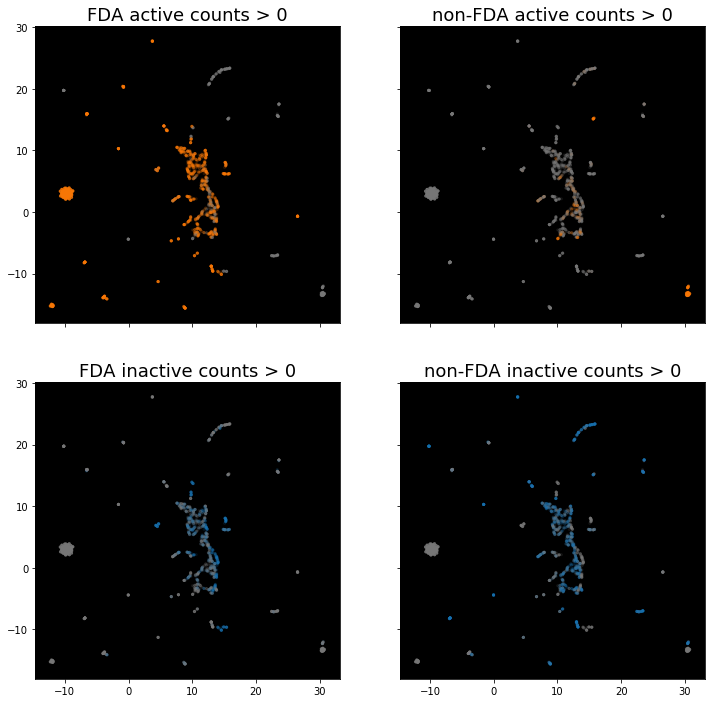

In [130]:
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row' ,figsize=(12, 12))

colors = [sns.color_palette()[1] if x >= 1.0 else sns.color_palette()[7] for x in df_counts.fda_active.values]

ax[0, 0].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[0, 0].set_title('FDA active counts > 0', fontsize=18);
ax[0, 0].set_facecolor((0.0, 0.0, 0.0))


colors = [sns.color_palette()[1] if x[0] == 0.0 and x[2] >= 1.0 else sns.color_palette()[7] for x in df_counts.values]

ax[0, 1].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[0, 1].set_title('non-FDA active counts > 0', fontsize=18);
ax[0, 1].set_facecolor((0.0, 0.0, 0.0))


colors = [sns.color_palette()[0] if x[1] >= 1.0 else sns.color_palette()[7] for x in df_counts.values]

ax[1, 0].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[1, 0].set_title('FDA inactive counts > 0', fontsize=18);
ax[1, 0].set_facecolor((0.0, 0.0, 0.0))


colors = [sns.color_palette()[0] if x[1] == 0.0 and x[3] >= 1.0 else sns.color_palette()[7] for x in df_counts.values]

ax[1, 1].scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=colors, s=5, alpha=0.1)
ax[1, 1].set_title('non-FDA inactive counts > 0', fontsize=18);
ax[1, 1].set_facecolor((0.0, 0.0, 0.0))

In [32]:
# load drug data column names
def get_drug_column_names():
    cid_dragon_features = get_csv_feature_names('drug_features/dragon_features.csv')

    # We renamed the dragon features columns in the greg-features notebook.
    cid_dragon_features = ['cid_'+col for col in cid_dragon_features]

    # We dropped columns that are < 2% filled with values in the greg-features notebook.
    empty_cols = ['cid_X0v', 'cid_X5A', 'cid_Psi_i_s', 'cid_SM6_B(s)', 'cid_Psychotic-80', 'cid_VE1sign_L', 'cid_X5sol', 'cid_Psi_e_1d', 'cid_X2Av', 'cid_ATS1s', 'cid_SpMin1_Bh(s)', 'cid_GATS3s', 'cid_SpMin8_Bh(s)', 'cid_MATS6s', 'cid_VR2_B(s)', 'cid_X1Av', 'cid_Ro5', 'cid_MLOGP', 'cid_SpMin6_Bh(s)', 'cid_ATSC3s', 'cid_VE3sign_D/Dt', 'cid_SpPos_B(s)', 'cid_GATS4s', 'cid_X1Kup', 'cid_X3sol', 'cid_EE_Dt', 'cid_X2sol', 'cid_ATS4s', 'cid_DLS_01', 'cid_SpMax4_Bh(s)', 'cid_WiA_B(s)', 'cid_Chi_B(s)', 'cid_Neoplastic-80', 'cid_ATSC4s', 'cid_DLS_07', 'cid_VR3_L', 'cid_SpMax6_Bh(s)', 'cid_Inflammat-50', 'cid_XMOD', 'cid_SpAbs_B(s)', 'cid_ATS6s', 'cid_VE3sign_D', 'cid_X5', 'cid_VR1_L', 'cid_MATS5s', 'cid_X3A', 'cid_SpAD_B(s)', 'cid_ATSC6s', 'cid_VE3sign_Dz(m)', 'cid_X0', 'cid_Psi_e_1', 'cid_X3v', 'cid_EE_D', 'cid_MLOGP2', 'cid_MATS2s', 'cid_EE_Dz(i)', 'cid_VE3sign_L', 'cid_CMC-80', 'cid_LLS_01', 'cid_X5v', 'cid_X4A', 'cid_PJI2', 'cid_Hypertens-80', 'cid_VE2sign_L', 'cid_X0A', 'cid_SpMax8_Bh(s)', 'cid_X1v', 'cid_VE2_B(s)', 'cid_X0sol', 'cid_EE_B(s)', 'cid_X5Av', 'cid_BLTA96', 'cid_Psi_i_0d', 'cid_VE3sign_Dz(p)', 'cid_GATS6s', 'cid_VR1_B(s)', 'cid_VE3_B(s)', 'cid_EE_Dz(p)', 'cid_MATS3s', 'cid_ATS5s', 'cid_X3Av', 'cid_VE3sign_Dz(i)', 'cid_SpMAD_B(s)', 'cid_VE1_B(s)', 'cid_ATS8s', 'cid_SpMax3_Bh(s)', 'cid_X1', 'cid_DLS_cons', 'cid_Hypnotic-80', 'cid_DLS_04', 'cid_SpMaxA_B(s)', 'cid_VE3sign_B(s)', 'cid_X1Mad', 'cid_SpMin4_Bh(s)', 'cid_MATS1s', 'cid_Psi_e_t', 'cid_Psi_i_0', 'cid_Infective-50', 'cid_DLS_05', 'cid_ChiA_B(s)', 'cid_X3', 'cid_SpMax_B(s)', 'cid_CMC-50', 'cid_BLI', 'cid_GATS5s', 'cid_VE3sign_Dz(e)', 'cid_VE1sign_B(s)', 'cid_VE2_L', 'cid_X4v', 'cid_SpMin5_Bh(s)', 'cid_DLS_06', 'cid_Depressant-80', 'cid_Psi_e_0', 'cid_ATS7s', 'cid_X1MulPer', 'cid_AMR', 'cid_ATS2s', 'cid_SM1_B(s)', 'cid_SM2_B(s)', 'cid_DLS_02', 'cid_ALOGP2', 'cid_Inflammat-80', 'cid_DLS_03', 'cid_ATSC5s', 'cid_GATS1s', 'cid_Psi_i_1s', 'cid_Infective-80', 'cid_X4', 'cid_EE_Dz(Z)', 'cid_RDCHI', 'cid_ATSC8s', 'cid_GATS8s', 'cid_EE_Dz(m)', 'cid_MATS8s', 'cid_Psi_e_0d', 'cid_SpMax7_Bh(s)', 'cid_VE1_L', 'cid_X2A', 'cid_VE2sign_B(s)', 'cid_cRo5', 'cid_BLTF96', 'cid_X4sol', 'cid_RDSQ', 'cid_GATS7s', 'cid_X2v', 'cid_Hypnotic-50', 'cid_VE3sign_Dz(v)', 'cid_Psi_i_A', 'cid_Psi_i_1', 'cid_HyWi_B(s)', 'cid_ATS3s', 'cid_VE3sign_X', 'cid_Wi_B(s)', 'cid_SM4_B(s)', 'cid_Psychotic-50', 'cid_J_B(s)', 'cid_X1A', 'cid_ATSC7s', 'cid_EE_Dz(e)', 'cid_SpMax1_Bh(s)', 'cid_Hypertens-50', 'cid_GATS2s', 'cid_X2', 'cid_VE3_L', 'cid_SpMax2_Bh(s)', 'cid_Psi_e_A', 'cid_Ho_B(s)', 'cid_SpMin3_Bh(s)', 'cid_AVS_B(s)', 'cid_VE3sign_Dt', 'cid_SpPosA_B(s)', 'cid_VR3_B(s)', 'cid_EE_Dz(v)', 'cid_MATS4s', 'cid_Psi_e_1s', 'cid_X1Per', 'cid_LLS_02', 'cid_X0Av', 'cid_X1sol', 'cid_Psi_i_t', 'cid_SpMax5_Bh(s)', 'cid_VE3sign_B(v)', 'cid_SM5_B(s)', 'cid_SpMin7_Bh(s)', 'cid_ALOGP', 'cid_X4Av', 'cid_SM3_B(s)', 'cid_ATSC1s', 'cid_Depressant-50', 'cid_SpMin2_Bh(s)', 'cid_BLTD48', 'cid_ATSC2s', 'cid_VE3sign_Dz(Z)', 'cid_SpDiam_B(s)', 'cid_Neoplastic-50', 'cid_Psi_i_1d', 'cid_VR2_L', 'cid_SpPosLog_B(s)', 'cid_MATS7s']
    
    # GR:THIS!
    cid_dragon_features = [col for col in cid_dragon_features if col not in empty_cols]
    
    cid_fingerprints = get_csv_feature_names('drug_features/fingerprints.csv')

    cid_features = cid_dragon_features + cid_fingerprints
    print()
    print('{:,} drug featues'.format(len(cid_features)))
    return cid_features


# load protein data column names
def get_protein_column_names():
    pid_binding_sites = get_csv_feature_names('protein_features/binding_sites_v1.0.csv')
    pid_expasy = get_csv_feature_names('protein_features/expasy.csv')
    pid_profeat = get_csv_feature_names('protein_features/profeat.csv')

    pid_features = pid_binding_sites + pid_expasy + pid_profeat
    print()
    print('{:,} protein featues'.format(len(pid_features)))
    return pid_features

# get only the feature names from a csv file
def get_csv_feature_names(file):
    columns = pd.read_csv(data_loc + file, index_col=0, nrows=1).columns.tolist()
    print('{}: columns: {:,}'.format(file, len(columns)))
    return columns

# Model for combined cid/pid features NOT using activity scores as sample weights.
def train_and_eval(df_in):
    Y = df_in['activity'].values
    df = df_in.copy()
    drop_non_features(df)
    X = df
    X.columns = list(range(0, len(X.columns)))

    # fit best model
    xgb = XGBClassifier(learning_rate=0.02, 
                        n_estimators=600, 
                        objective='binary:logistic',
                        subsample=0.6,
                        min_child_weight=1,
                        max_depth=6,
                        gamma=5,
                        colsample_bytree=0.8)

    model = train(X, Y, random_state=42, xgb=xgb, evaluate=False)
    del df

    # load test data and gather metrics
    gather_metrics(df_in, model)
    return model

def drop_non_features(df):
    if 'index' in df:
        df.drop('index', axis=1, inplace=True)
    if 'activity' in df:
        df.drop('activity', axis=1, inplace=True)
    if 'cid' in df:
        df.drop('cid', axis=1, inplace=True)
    if 'pid' in df:
        df.drop('pid', axis=1, inplace=True)
    if 'expanding_mean' in df:
        df.drop('expanding_mean', axis=1, inplace=True)
    if 'sample_activity_score' in df:
        df.drop('sample_activity_score', axis=1, inplace=True)


# load test data and gather metrics
def gather_metrics(df_in, model):
    store = pd.HDFStore(data_loc + 'validation_features.h5')
    df_test_features = pd.DataFrame(store['df' ])
    store.close()
    print('rows: {:,}, columns: {:,}'.format(len(df_test_features), len(df_test_features.columns)))

    # Take only the reduced set of columns.
    df_test_features = df_test_features[df_in.columns.tolist()]

    print('rows: {:,}, columns: {:,}'.format(len(df_test_features), len(df_test_features.columns)))

    # accuracy, precision and recall
    y_test = df_test_features['activity'].values
    df = df_test_features.copy()
    drop_non_features(df)
    X_test = df

    X_test.columns = list(range(0, len(X_test.columns)))

    # make predictions for test data
    y_pred = model.predict(X_test)

    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy = {:0.2f}%".format(sum(diag(cm))/sum(cm)*100))
    print("Precision = {:0.2f}%".format(cm[1][1]/sum(cm[:, 1])*100))
    print("Recall = {:0.2f}%".format(cm[1][1]/sum(cm[1, :])*100))

    # weighted F1 score
    training_features_active = df_in[df_in['activity']==1]
    training_features_inactive = df_in[df_in['activity']==0]
    
    drop_non_features(training_features_active)
    drop_non_features(training_features_inactive)

    validation_features_active = df_test_features[df_test_features['activity']==1]
    validation_features_inactive = df_test_features[df_test_features['activity']==0]
    
    drop_non_features(validation_features_active)
    drop_non_features(validation_features_inactive)

    active_weights, inactive_weights = get_validation_weights(
        training_features_active, 
        training_features_inactive,
        validation_features_active, 
        validation_features_inactive)

    assert(len(inactive_weights) + len(active_weights) == len(df_test_features))

    df_validation_features = validation_features_active.append(validation_features_inactive)

    weights = list(active_weights) + list(inactive_weights)

    f1score = f1_score(y_test, y_pred, average='binary', sample_weight=weights)

    print('F1 Score (weighted): {:0.2f}%'.format(f1score*100))
    
    f1score_unweighted = f1_score(y_test, y_pred, average='binary')
    print('F1 Score (unweighted): {:0.2f}%'.format(f1score_unweighted*100))
    
    return model.predict_proba(X_test)

# load the models
combined_model_ = joblib.load(data_loc + 'combined_model.mdl')
drugs_model_ = joblib.load(data_loc + 'drugs_model.mdl')
proteins_model_ = joblib.load(data_loc + 'proteins_model.mdl')

# get the features
store = pd.HDFStore(data_loc + 'xgboost_features_exp5_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('df_features - rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

features = df_features.columns.tolist()

# cid set with subset of features derived from previous cid/pid combined dimension reduction


# GR: /THIS
drug_column_names = get_drug_column_names()
cid_features = [col for col in features if col in drug_column_names]



df_drugs = df_features[['activity', 'sample_activity_score']+cid_features]
print('df_drugs - rows: {:,}, columns: {:,}'.format(len(df_drugs), len(df_drugs.columns)))

# pid set with subset of features derived from previous cid/pid combined dimension reduction

# GR: /THIS
protein_column_names = get_protein_column_names()
pid_features = [col for col in features if col in protein_column_names]




df_proteins = df_features[['activity', 'sample_activity_score']+pid_features]
print('df_proteins - rows: {:,}, columns: {:,}'.format(len(df_proteins), len(df_proteins.columns)))

df_features - rows: 88,353, columns: 3,169
drug_features/dragon_features.csv: columns: 3,839
drug_features/fingerprints.csv: columns: 4,096

7,736 drug featues
df_drugs - rows: 88,353, columns: 1,678
protein_features/binding_sites_v1.0.csv: columns: 8,481
protein_features/expasy.csv: columns: 7
protein_features/profeat.csv: columns: 849

9,337 protein featues
df_proteins - rows: 88,353, columns: 1,493


In [33]:
cid_features[:3]

['cid_SpMax2_Bh(i)', 'cid_P_VSA_v_3', 'cid_P_VSA_m_2']

In [34]:
store = pd.HDFStore(data_loc + 'validation_features.h5')
df_test_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_test_features), len(df_test_features.columns)))

# Take only the reduced set of columns.
drug_features = ['activity', 'sample_activity_score']+cid_features
df_test_features = df_test_features[drug_features]

print('rows: {:,}, columns: {:,}'.format(len(df_test_features), len(df_test_features.columns)))

# accuracy, precision and recall
y_test = df_test_features['activity'].values
X_test = df_test_features.drop(['activity', 'sample_activity_score'], axis=1)

X_test.columns = list(range(0, len(X_test.columns)))

# make predictions for test data
y_pred = drugs_model_.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)

print("Accuracy = {:0.2f}%".format(sum(diag(cm))/sum(cm)*100))
print("Precision = {:0.2f}%".format(cm[1][1]/sum(cm[:, 1])*100))
print("Recall = {:0.2f}%".format(cm[1][1]/sum(cm[1, :])*100))

rows: 18,949, columns: 17,079
rows: 18,949, columns: 1,678
Accuracy = 23.91%
Precision = 23.91%
Recall = 100.00%


In [ ]:
# Save X and Y to file
store = pd.HDFStore(data_loc + 'training_features.h5')
df_features = pd.DataFrame(store['df' ])
store.close()

# Filter by activity threshold
df = df_features[df_features['sample_activity_score'] > 0.05]
del df_features
print('threshold filtered df - rows: {:,}, columns: {:,}'.format(len(df), len(df.columns)))

# Drop zero-variance columns
var_cols = [col for col in df.columns if df[col].nunique() > 1]
df_features = df[var_cols]
del df
print('df_features with zero-variance cols dropped - rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

# Split
Y = df_features['activity'].values
X = df_features.drop(['index', 'activity', 'cid', 'pid', 'sample_activity_score', 'expanding_mean'], axis=1).values

print(X.shape)
print(Y.shape)

pickle_out = open('~/Desktop/X.pck',"wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open('~/Desktop/Y.pck',"wb")
pickle.dump(Y, pickle_out)
pickle_out.close()

In [ ]:
features_005_file = '../data/features_at_threshold/features_text_005.csv'

features_005 = open(features_005_file, 'rb')
features_005 = pickle.load(features_005)

len(features_005)

#### Determmine from which data sets the XGBoost reduced features are taken

...for _sample_activity_score > 0.2_

In [28]:
def get_xgboost_feature_names(file):
    store = pd.HDFStore(data_loc + file)
    meta = store.select('df', start=1, stop=1)
    store.close()
    print('{}: columns: {:,}'.format(file, len(meta.columns)))
    return set(list(meta.columns))

# load the xgboost-reduced feature names.
xgb_features = get_xgboost_feature_names('xgboost_features3_data.h5')

def get_csv_feature_names(file):
    columns = pd.read_csv(data_loc + file, index_col=0, nrows=1).columns.tolist()
    print('{}: columns: {:,}'.format(file, len(columns)))
    return set(columns)

# load protein data
pid_binding_sites = get_csv_feature_names('protein_features/binding_sites_v1.0.csv')
pid_expasy = get_csv_feature_names('protein_features/expasy.csv')
pid_profeat = get_csv_feature_names('protein_features/profeat.csv')
pid_porter = get_csv_feature_names('protein_features/porter.csv')

# load drug data
cid_dragon_features = get_csv_feature_names('drug_features/dragon_features.csv')
cid_fingerprints = get_csv_feature_names('drug_features/fingerprints.csv')

# number of features from each data set
print()
pid_binding_sites_num = len(xgb_features.intersection(pid_binding_sites))
print('{}: {:,} features used out of a total of {:,}'.format('pid_binding_sites', pid_binding_sites_num, len(pid_binding_sites)))

pid_expasy_num = len(xgb_features.intersection(pid_expasy))
print('{}: {:,} features used out of a total of {:,}'.format('pid_expasy', pid_expasy_num, len(pid_expasy)))

pid_profeat_num = len(xgb_features.intersection(pid_profeat))
print('{}: {:,} features used out of a total of {:,}'.format('pid_profeat', pid_profeat_num, len(pid_profeat)))

pid_porter_num = len(xgb_features.intersection(pid_porter))
print('{}: {:,} features used out of a total of {:,}'.format('pid_porter', pid_porter_num, len(pid_porter)))

# remane dragon features to match ones in greg-features.ipynb (they were renamed because of duplicate column names in protein binding sites).
cid_dragon_features = ['cid_'+col for col in cid_dragon_features]
cid_dragon_features_num = len(xgb_features.intersection(cid_dragon_features))
print('{}: {:,} features used out of a total of {:,}'.format('cid_dragon_features', cid_dragon_features_num, len(cid_dragon_features)))

cid_fingerprints_num = len(xgb_features.intersection(cid_fingerprints))
print('{}: {:,} features used out of a total of {:,}'.format('cid_fingerprints', cid_fingerprints_num, len(cid_fingerprints)))

xgboost_features3_data.h5: columns: 874
protein_features/binding_sites_v1.0.csv: columns: 8,481
protein_features/expasy.csv: columns: 7
protein_features/profeat.csv: columns: 849
protein_features/porter.csv: columns: 7
drug_features/dragon_features.csv: columns: 3,839
drug_features/fingerprints.csv: columns: 4,096

pid_binding_sites: 164 features used out of a total of 8,481
pid_expasy: 4 features used out of a total of 7
pid_profeat: 375 features used out of a total of 849
pid_porter: 4 features used out of a total of 7
cid_dragon_features: 290 features used out of a total of 3,839
cid_fingerprints: 32 features used out of a total of 4,096


In [31]:
# class balance for _sample_activity_score > 0.1_

store = pd.HDFStore(data_loc + 'xgboost_features2_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

num_active = len(df_features[df_features['activity']==1])
num_inactive = len(df_features[df_features['activity']==0])
print('num active: {:,}. num inactive: {:,}'.format(num_active, num_inactive))

rows: 66,923, columns: 894
num active: 18,864. num inactive: 48,059


In [32]:
# class balance for _sample_activity_score > 0._

store = pd.HDFStore(data_loc + 'xgboost_features3_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

num_active = len(df_features[df_features['activity']==1])
num_inactive = len(df_features[df_features['activity']==0])
print('num active: {:,}. num inactive: {:,}'.format(num_active, num_inactive))

rows: 45,616, columns: 874
num active: 15,361. num inactive: 30,255


In [37]:
store = pd.HDFStore(data_loc + 'sampled_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

df_features.head()

rows: 22,172, columns: 13,851


,cid,pid,activity,AEK,VEL,EKF,LGM,VKN,LKP,NEE,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
58,204,Q99VQ4,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
97,204,EDT84149,0,3.936758,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
98,204,AAX80043,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0
126,204,P0C6X7,1,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,2.367871,...,0,0,0,0,0,0,0,0,0,0
136,8549,P08659,0,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,...,0,0,0,0,0,0,0,0,0,0


### UMAP

pip install umap-learn

reference material:

* [How UMAP Works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)
* [How to Use UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html)
* [Basic UMAP Parameters](https://umap-learn.readthedocs.io/en/latest/parameters.html)
* [UMAP API Guide](https://umap-learn.readthedocs.io/en/latest/api.html)
* [UMAP for Supervised Dimension Reduction and Metric Learning](https://umap-learn.readthedocs.io/en/latest/supervised.html)

### UMAP on MinMax-scaled cenrtoid-sampled data without supervision

In [38]:
X = MinMaxScaler().fit_transform(df_features.drop(['cid', 'pid', 'activity'], axis=1))
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding_sampled = reducer.fit_transform(X)

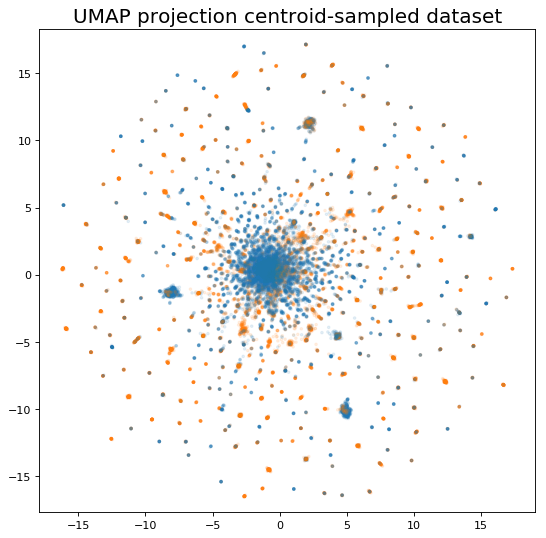

In [39]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_sampled[:, 0], embedding_sampled[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection centroid-sampled dataset', fontsize=18);

#### highlight the most frequent pids

In [102]:
def plot_freq(df, embedding, groupby='pid', threshold=100):
    frequent_pids = [(name, group) for (name, group) in df.groupby(groupby).groups.items() if len(group) > threshold]
    frequent_pids.sort(key=lambda x: len(x[1]))
    frequent_pids = [x for x, y in frequent_pids][:9]

    lookup = {}
    for i, key in enumerate(frequent_pids):
        if i+1 == 7:
            lookup[key] = 0
        else:
            lookup[key] = i+1

    colors = [sns.color_palette(palette='muted')[lookup.get(x, 7)] for x in df[groupby].values]

    # color according to pid
    plt.figure(figsize=(8, 8), dpi=80)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=5, alpha=0.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP: XGBOOST-selected features(737) highlighted by frequent {}s'.format(groupby), fontsize=18);
    ax = plt.gca()
    ax.set_facecolor((0.0, 0.0, 0.0))

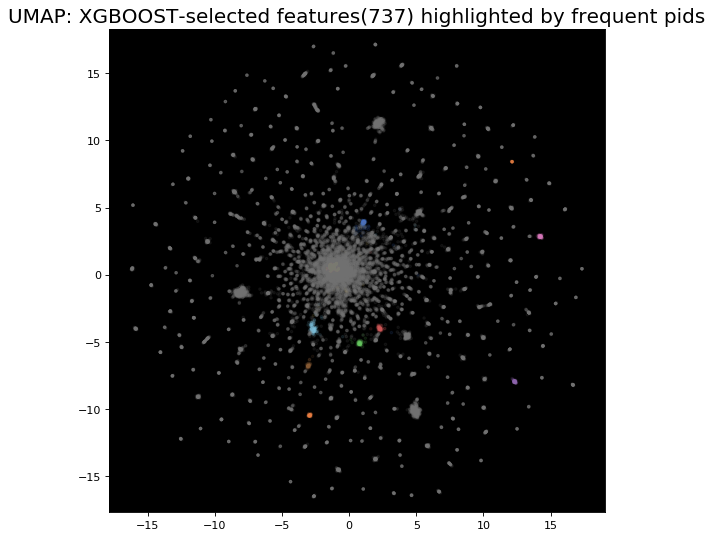

In [59]:
# color according to pid
plot_freq(df_features, embedding_sampled, groupby='pid')

#### umap color by FDA-approved

In [62]:
def fda_plot(df, embedding):
    fda = pd.read_csv(data_loc+'fda_drug_cids.csv', index_col=0).values.flatten()
    colors = []

    for x in df[['cid', 'activity']].values:
        if str(x[0]) in fda:
            colors.append(sns.color_palette(palette='muted')[x[1]])
        else:
            colors.append(sns.color_palette(palette='muted')[7])

    # color according to pid
    plt.figure(figsize=(8, 8), dpi=80)
    plt.scatter(embedding[:, 0], embedding[:, 1], c=colors, s=5, alpha=0.1)
    plt.gca().set_aspect('equal', 'datalim')
    plt.title('UMAP: XGBOOST-selected features(737) highlighted by FDA approval and (in)active', fontsize=18);
    ax = plt.gca()
    ax.set_facecolor((0.0, 0.0, 0.0))

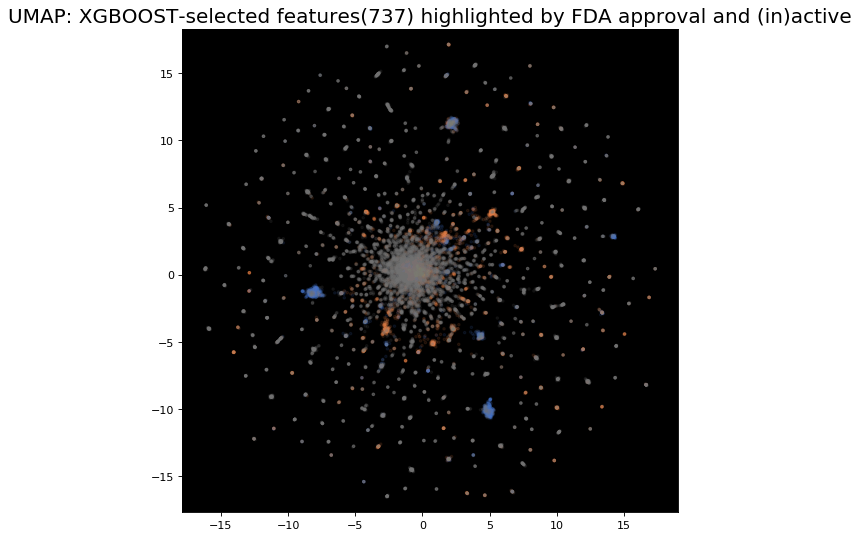

In [65]:
fda_plot(df_features, embedding_sampled)

#### umap on xgboost-identified features

In [71]:
store = pd.HDFStore(data_loc + 'xgboost_features_data.h5')
df_features = pd.DataFrame(store['df' ])
store.close()
print('rows: {:,}, columns: {:,}'.format(len(df_features), len(df_features.columns)))

df_features.head()

rows: 22,172, columns: 737


,cid,pid,activity,YN*,SpMax3_Bh(p),*YN,*TS,TPC_y,IDM_y,Wap,...,*KP,D/Dtr09,GATS2m,B04_N-O_,SsssN,P_VSA_MR_7,2684,3191,N%,JGI4
58,204,Q99VQ4,1,-1.000000,2.586,-1.000000,-1.000000,4.700,5.597,379.0,...,-1.000000,0.0,0.657,1.0,0.000,0.000,0,0,23.5,0.044
97,204,EDT84149,0,4.781462,2.586,4.317575,4.238781,4.700,5.597,379.0,...,-1.000000,0.0,0.657,1.0,0.000,0.000,0,0,23.5,0.044
98,204,AAX80043,0,5.092332,2.586,4.020370,4.652062,4.700,5.597,379.0,...,-1.000000,0.0,0.657,1.0,0.000,0.000,0,0,23.5,0.044
126,204,P0C6X7,1,2.857035,2.586,3.831240,2.691626,4.700,5.597,379.0,...,2.955727,0.0,0.657,1.0,0.000,0.000,0,0,23.5,0.044
136,8549,P08659,0,-1.000000,3.438,-1.000000,-1.000000,7.549,7.886,18832.0,...,-1.000000,0.0,0.992,0.0,2.434,26.262,0,0,4.2,0.046


In [72]:
X = MinMaxScaler().fit_transform(df_features.drop(['cid', 'pid', 'activity'], axis=1))
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding = reducer.fit_transform(X)

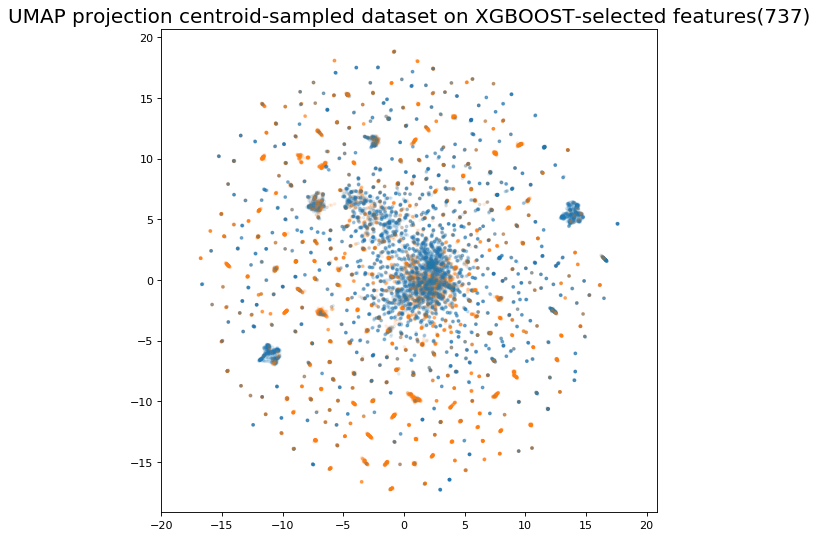

In [73]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection centroid-sampled dataset on XGBOOST-selected features(737)', fontsize=18);

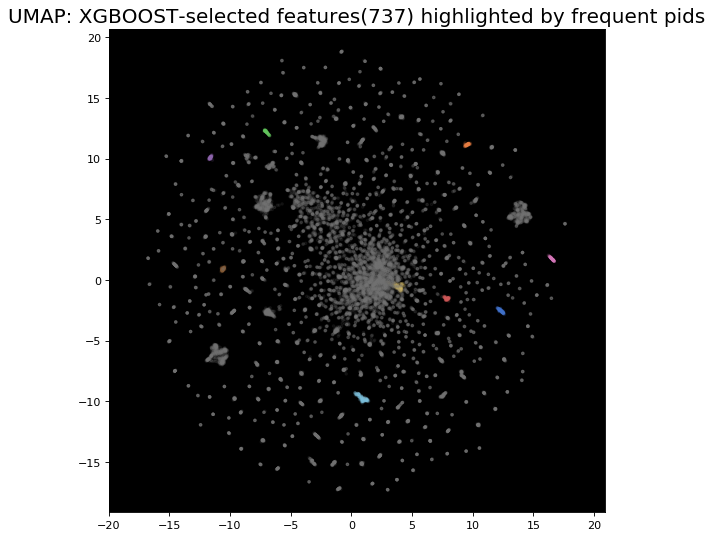

In [77]:
plot_freq(df_features, embedding, groupby='pid')

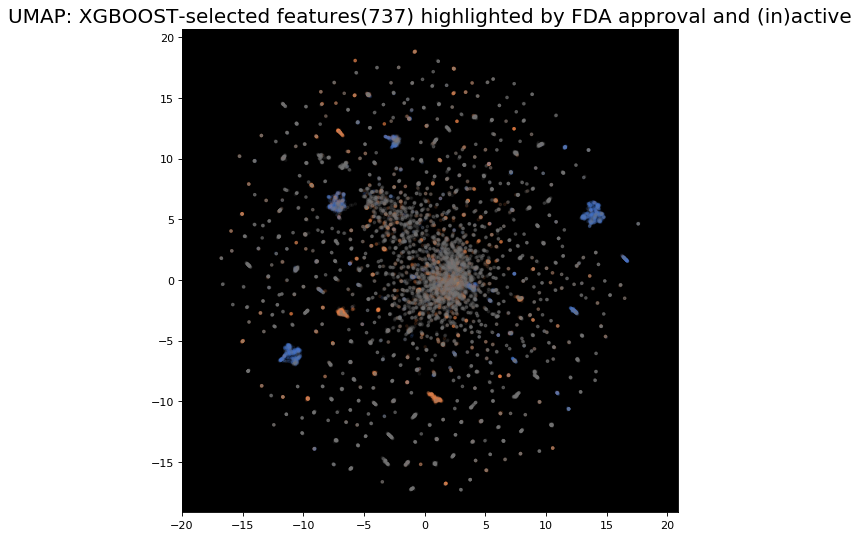

In [75]:
fda_plot(df_features, embedding)

In [78]:
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
df_all_features = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_all_features), len(df_all_features.columns)))
store.close()

rows: 184,063, columns: 14,730


In [79]:
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
df_all_features.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df_all_features.columns.values]

df_reduced = df_all_features[df_features.columns]
df_reduced.shape

(184063, 737)

In [80]:
X = df_reduced.drop(['cid', 'pid', 'activity'], axis=1).values
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3)
embedding = reducer.fit_transform(X)

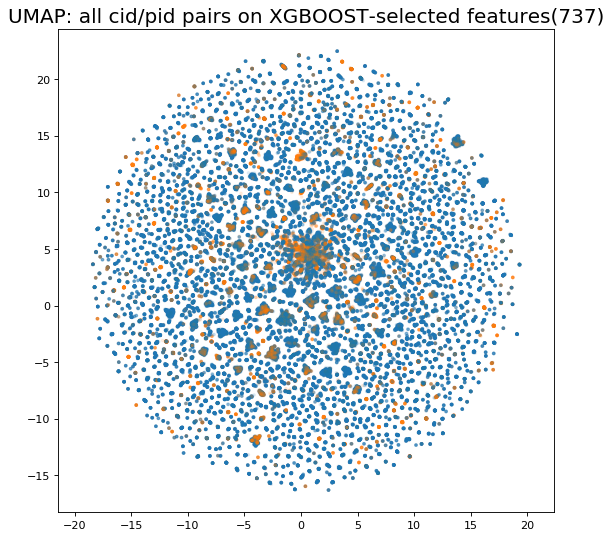

In [81]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_all_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP: all cid/pid pairs on XGBOOST-selected features(737)', fontsize=18);

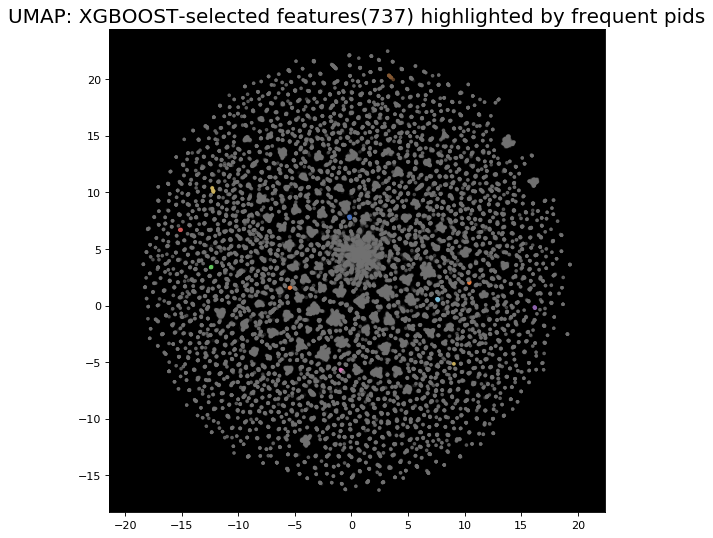

In [103]:
plot_freq(df_reduced, embedding)

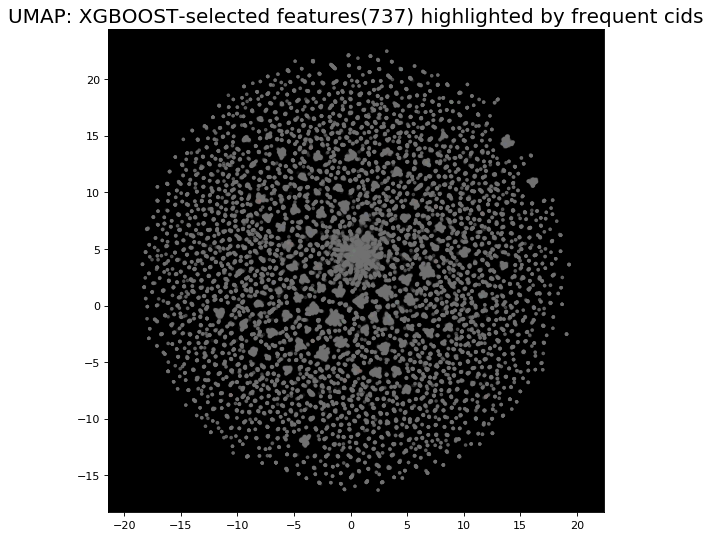

In [104]:
plot_freq(df_reduced, embedding, 'cid', 10)

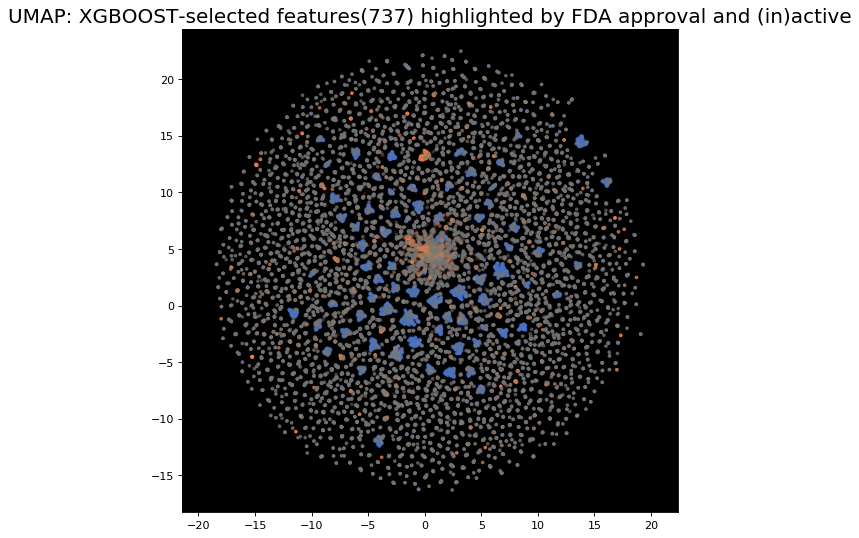

In [84]:
fda_plot(df_reduced, embedding)

#### Scale the centroid-sampled data and retrain umap (supervised)

In [5]:
# scale only the cols_to_keep
scaler = StandardScaler()
features = df_features[cols_to_keep]
df_features[cols_to_keep] = scaler.fit_transform(features.values)
del features

In [6]:
df_features.drop(columns=['cid', 'pid'], axis=1, inplace=True)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine')
embedding = reducer.fit_transform(df_features.values, y=df_features['activity'].values)

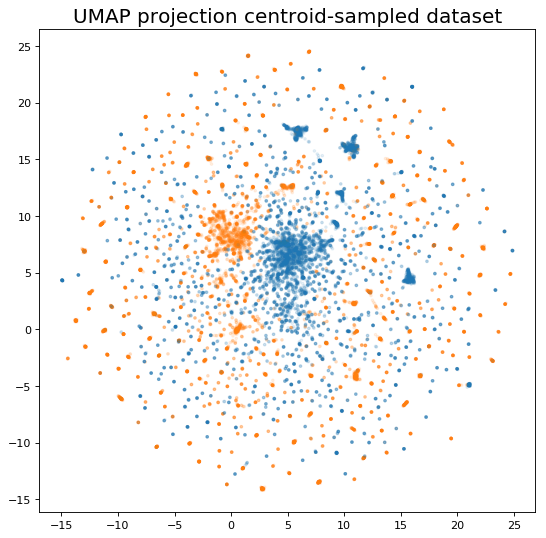

In [7]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection centroid-sampled dataset', fontsize=18);

#### fit scaled, full dataset to umap

Scaled data set from the dbscan.ipynb notebook.

In [8]:
store = pd.HDFStore(data_loc + 'dbscan_scaled_data.h5')
df_all_features = pd.DataFrame(store['df' ])
print('rows: {:,}, columns: {:,}'.format(len(df_all_features), len(df_all_features.columns)))
store.close()

rows: 184,063, columns: 14,730


In [9]:
df_dropped = df_all_features[['cid', 'pid', 'activity']]

In [10]:
df_all_features.drop(columns=['cid', 'pid', 'activity'], axis=1, inplace=True)
embedding_full = reducer.transform(df_all_features.values)

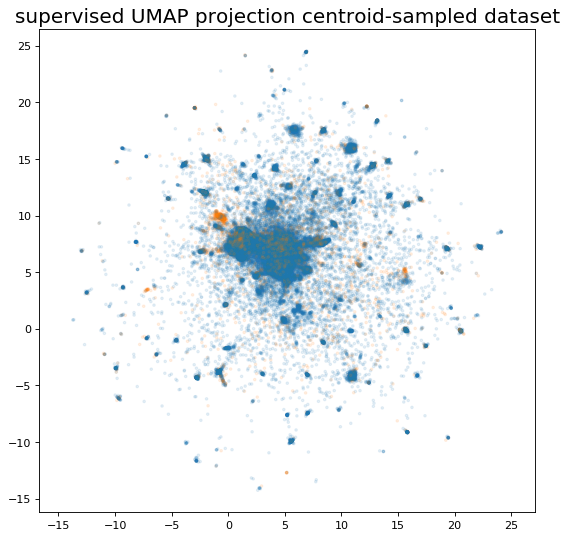

In [11]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_full[:, 0], embedding_full[:, 1], c=[sns.color_palette()[x] for x in df_dropped.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('supervised UMAP projection centroid-sampled dataset', fontsize=18);

#### superimpose both embeddings

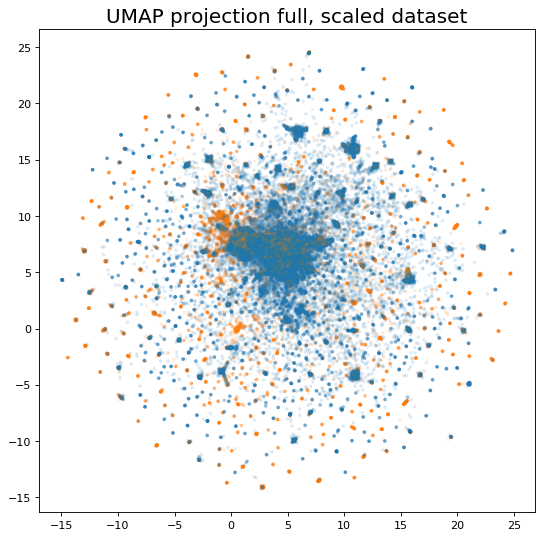

In [12]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding[:, 0], embedding[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.scatter(embedding_full[:, 0], embedding_full[:, 1], c=[sns.color_palette()[x] for x in df_dropped.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection full, scaled dataset', fontsize=18);

#### Fit scaled, centroid-based sample data (unsupervised)

In [13]:
X = df_features.drop(columns=['activity'], axis=1).values
reducer = umap.UMAP(n_neighbors=15, min_dist=0.3, metric='cosine')
embedding_unsup = reducer.fit_transform(X)

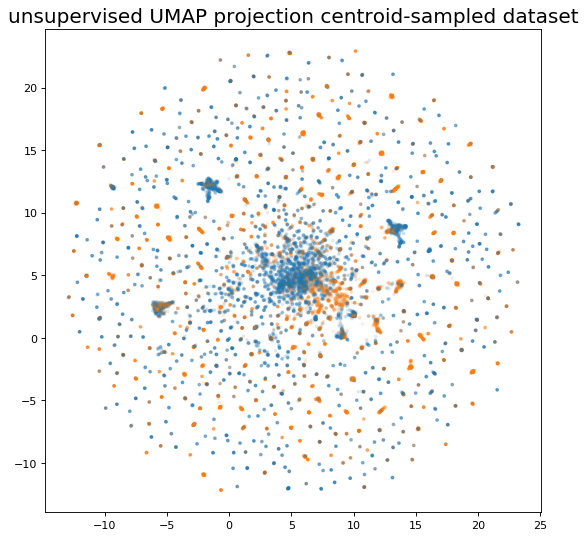

In [14]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_unsup[:, 0], embedding_unsup[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('unsupervised UMAP projection centroid-sampled dataset', fontsize=18);

#### Fit scaled, centroid-based sample data (unsupervised)

metric = eulidean

In [19]:
reducer = umap.UMAP(n_neighbors=50, min_dist=0.5)
embedding_unsup = reducer.fit_transform(X)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/manifold/spectral_embedding_.py:237: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


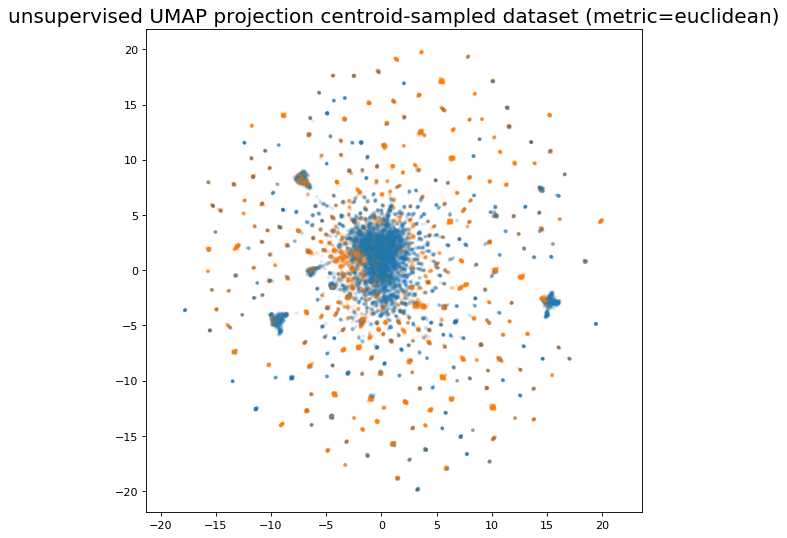

In [20]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(embedding_unsup[:, 0], embedding_unsup[:, 1], c=[sns.color_palette()[x] for x in df_features.activity.values], s=5, alpha=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('unsupervised UMAP projection centroid-sampled dataset (metric=euclidean)', fontsize=18);

## Check column variance

How many columns have zero variance? We can drop those.

In [24]:
no_var_cols = [col for col in df_features.columns if df_features[col].nunique() == 1]

len(no_var_cols)

0

In [ ]:
var_cols = [col for col in df_features.columns if df_features[col].nunique() > 1]
df_novar_cols_dropped = df_features[var_cols].copy()

print('Dropped {:,} columns that have zero variance.'.format(len(df_features.columns)-len(var_cols)))

print('rows: {:,}, columns: {:,}'.format(len(df_novar_cols_dropped), len(df_novar_cols_dropped.columns)))

## Scale the data

In [ ]:
df_features.drop(columns=['cid', 'pid', 'activity'], inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_features.values)

In [ ]:
scaled_data.T[1000].mean()

## Find highly correlated columns

In [ ]:
df_scaled = pd.DataFrame(scaled_data, columns=df_features.columns)

In [ ]:
df_scaled.head()

In [ ]:
a = [0, 1, 2, 3, 4, 5, 6]

res = [(x, y) for i,x in enumerate(a) for j,y in enumerate(a) if i > j]

res

In [ ]:
b = [1,1,2,3,4,5,6]
np.corrcoef(a, b)[0][1]

In [ ]:
from IPython.display import display, clear_output

cols = df_scaled.columns.tolist()

corr_cols = []

def func(x, y):
    i = len(corr_cols)
    clear_output(wait=True)
    display('processed column {:,}'.format(i))
        
    corr_cols.append(x)
    return (x, y)
    

out = [func(x, y) for i,x in enumerate(cols) for j,y in enumerate(cols) if i > j and 
       np.corrcoef(df_scaled[x], df_scaled[y])[0][1] > 0.9]

In [ ]:
len(out)

## Find correlated columns within the fingerpirnt data

In [4]:
df_fingerprints = pd.read_csv(data_loc+'drug_features/fingerprints.csv', index_col=0)

print('Number of rows: {:,}\n'.format(len(df_fingerprints)))
print('Number of columns: {:,}\n'.format(len(df_fingerprints.columns)))

Number of rows: 91,756

Number of columns: 4,096



In [5]:
num_cols = len(df_fingerprints.columns)
num_pairwise_ops = (num_cols**2-num_cols)/2.0
num_pairwise_ops

8386560.0

In [ ]:
# See which correlation method is fastest:

In [ ]:
%%timeit
np.corrcoef(df_fingerprints['1947'], df_fingerprints['389'])

### See https://stackoverflow.com/questions/33650188/efficient-pairwise-correlation-for-two-matrices-of-features

In [ ]:
fingerprint_cols = df_fingerprints.columns.tolist()
df_sampled_fingerprint = df_features[fingerprint_cols].sample(n=1000, random_state=23)

In [ ]:
# Get number of rows in either A or B
N = len(df_sampled_fingerprint)

def corr_func(a, b):
    A = np.array([df_sampled_fingerprint[a].values]).T
    B = np.array([df_sampled_fingerprint[b].values]).T

    # Store columnw-wise in A and B, as they would be used at few places
    sA = A.sum(0)
    sB = B.sum(0)

    # Basically there are four parts in the formula. We would compute them one-by-one
    p1 = N*np.dot(B.T,A)
    p2 = sA*sB[:,None]
    p3 = N*((B**2).sum(0)) - (sB**2)
    p4 = N*((A**2).sum(0)) - (sA**2)

    # Finally compute Pearson Correlation Coefficient as 2D array 
    pcorr = ((p1 - p2)/np.sqrt(p4*p3[:,None]))

    # Get the element corresponding to absolute argmax along the columns 
    return pcorr[np.nanargmax(np.abs(pcorr),axis=0),np.arange(pcorr.shape[1])][0]

In [ ]:
%%timeit
corr_func('1947', '389')

In [ ]:
# corr_func is faster than np.corrcoef

In [ ]:
from IPython.display import display, clear_output

cols = df_sampled_fingerprint.columns.tolist()

corr_cols = []

def func(x, y):
    i = len(corr_cols)
    clear_output(wait=True)
    display('processed column pair {:,} out of {:,}'.format(i, num_pairwise_ops))
        
    corr_cols.append(x)
    return (x, y)
    

out = [func(x, y) for i,x in enumerate(cols) for j,y in enumerate(cols) if i > j and 
       corr_func(x, y) > 0.9]

In [ ]:
# It's still really slow

In [ ]:
out

### Let's try https://deepgraph.readthedocs.io/en/latest/tutorials/pairwise_correlations.html

In [5]:
#df = pd.read_csv(data_loc+'drug_features/fingerprints.csv', index_col=0)
df = pd.read_csv(data_loc+'protein_features/binding_sites_v1.0.csv', index_col=0)

print('Number of rows: {:,}\n'.format(len(df)))
print('Number of columns: {:,}\n'.format(len(df.columns)))

Number of rows: 4,165

Number of columns: 8,481



In [6]:
# use only the rows from the sampled data set
# and only the columns from the fingerprints data
df_cols = df.columns.tolist()
cols = df_features.columns.intersection(df_cols)
df_sampled = df_features[cols]

del df
del df_features

In [7]:
df_sampled.shape

(22172, 8417)

In [ ]:
import os
from multiprocessing import Pool
import deepgraph as dg

In [9]:
# create observations
from numpy.random import RandomState
prng = RandomState(0)
n_features = len(df_sampled.columns)
n_samples = 1000

# run over a sample of the rows. Can do this multiple times and take consensus.
X = df_sampled.sample(n=n_samples, random_state=23).values.T

# whiten variables for fast parallel computation later on
X = (X - X.mean(axis=1, keepdims=True)) / X.std(axis=1, keepdims=True)

# save in binary format
np.save(data_loc+'samples', X)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [11]:
import subprocess

# delete old correlation files
subprocess.run('rm {}correlations/*'.format(data_loc), shell=True)

CompletedProcess(args='rm ../data/FDA-COVID19_files_v1.0/correlations/*', returncode=1)

In [12]:
step_size = 5e2
n_processes = 1500

# load samples as memory-map
del X
X = np.load(data_loc+'samples.npy', mmap_mode='r')

# create node table that stores references to the mem-mapped samples
v = pd.DataFrame({'index': range(X.shape[0])})

# connector function to compute pairwise pearson correlations
# index_s and index_t are equal length arrays of indices for pairwise correlation
def corr(index_s, index_t):
    features_s = X[index_s].T
    features_t = X[index_t].T
    
    c = 1./(n_samples - 1)
    cov_xy = c * np.dot(features_s.T, features_t)
    var_x = c * np.sum(features_s**2, axis=0)
    var_y = c * np.sum(features_t**2, axis=0)
    corrcoef_xy = cov_xy / np.sqrt(var_x[:, None] * var_y[None,:])
    corr = np.diag(corrcoef_xy)
    
    del cov_xy
    del var_x
    del var_y
    del corrcoef_xy
    
    #if 1947 in index_t:
    #    print('corrcoef_xy shape: {}, index_s shape: {}, index_t shape: {}'.format(corrcoef_xy.shape, index_s.shape, index_t.shape))
    
    return corr
    

# index array for parallelization
pos_array = np.array(np.linspace(0, n_features*(n_features-1)//2, n_processes), dtype=int)

# parallel computation
def create_ei(i):

    from_pos = pos_array[i]
    to_pos = pos_array[i+1]

    # initiate DeepGraph
    g = dg.DeepGraph(v)

    # create edges
    g.create_edges(connectors=corr, step_size=step_size,
                   from_pos=from_pos, to_pos=to_pos)

    # store edge table
    g.e.to_pickle((data_loc+'correlations/{}.pickle').format(str(i).zfill(3)))

# computation
if __name__ == '__main__':
    os.makedirs(data_loc+'correlations/', exist_ok=True)
    indices = np.arange(0, n_processes - 1)
    p = Pool()
    for _ in p.imap_unordered(create_ei, indices):
        pass

In [13]:
# store correlation values
files = os.listdir(data_loc+'correlations/')
files.sort()
store = pd.HDFStore(data_loc+'e.h5', mode='w')
for f in files:
    #print((data_loc+'correlations/{}').format(f))
    et = pd.read_pickle((data_loc+'correlations/{}').format(f))
    store.append('e', et, format='t', data_columns=True, index=False)
store.close()

In [14]:
# load correlation table
e = pd.read_hdf(data_loc+'e.h5')

In [15]:
len(e)

35418736

In [ ]:
col1 = df_fingerprints.columns.get_loc('1947')
col2 = df_fingerprints.columns.get_loc('389')

In [80]:
e.abs().max()

corr    1.0
dtype: float64

In [62]:
e.query('s == 389 and t == 1947')

,,corr
s,t,
389,1947,0.962531


In [16]:
e2 = e.abs()
len(e2[e2['corr'] > 0.9])

3301

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x28c2e4208>]],
      dtype=object)

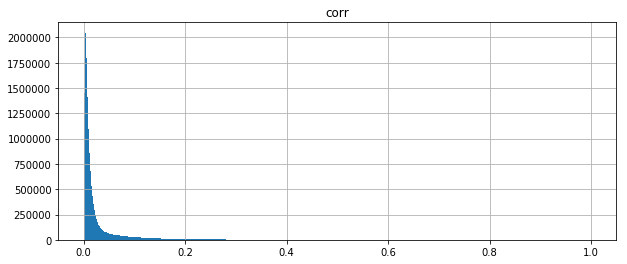

In [17]:
e.abs().hist(bins=1000, figsize=(10,4))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x29e0c1710>]],
      dtype=object)

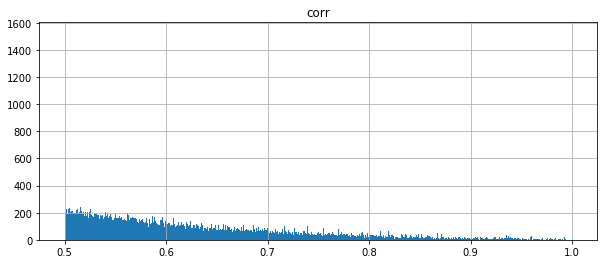

In [18]:
e2[e2['corr'] > 0.5].hist(bins=1000, figsize=(10,4))

### XY Pearson correlation

https://stackoverflow.com/questions/41538254/memory-efficient-ways-of-computing-large-correlation-matrices?rq=1

In [14]:
x = X[[1947]].T
y = X[[389]].T

samples = x.shape[0]
c = 1./(samples - 1)
cov_xy = c * np.dot(x.T, y)
var_x = c * np.sum(x**2, axis=0)
var_y = c * np.sum(y**2, axis=0)
corrcoef_xy = cov_xy / np.sqrt(var_x[:, None] * var_y[None,:])

corrcoef_xy

array([[0.9625312]])

### np.einsum for calculating pearson's correlation

https://stackoverflow.com/questions/50323786/compute-correlation-in-numpy

In [9]:
ma = np.random.random((5,6)).T
mb = np.random.random((5,6)).T
 
za = ma - ma.mean(axis=1, keepdims=True)
za /= np.sqrt(np.einsum('ij,ij->i', za, za))[:, None]
zb = mb - mb.mean(axis=1, keepdims=True)
zb /= np.sqrt(np.einsum('ij,ij->i', zb, zb))[:, None]
 
cc = np.einsum('ik,jk', za, zb)

#np.allclose(cc, np.corrcoef(ma, mb)[:5, 5:])
cc.shape

(6, 6)

In [10]:
za = ma - ma.mean(axis=1, keepdims=True)
za /= np.sqrt(np.einsum('ij,ij->i', za, za))[:, None]
cc = np.einsum('ik,jk', za, za)
cc.shape

(6, 6)

In [20]:
za

array([[ 0.41655389, -0.17400035, -0.76742633,  0.07599897,  0.44887383],
       [-0.55733007,  0.80813066, -0.01135404, -0.05843796, -0.18100859],
       [-0.51054979,  0.26521874, -0.5737303 ,  0.36262266,  0.45643869],
       [-0.47932298, -0.04737243, -0.49224991,  0.56679005,  0.45215527],
       [-0.59223603, -0.20378343,  0.58535125, -0.24316423,  0.45383243],
       [-0.48578584,  0.36408273, -0.27625728,  0.68680781, -0.28884742]])

In [11]:
cc2 = np.corrcoef(ma)

In [12]:
cc

array([[ 1.        , -0.44975089,  0.41391842,  0.43238064, -0.47522053,
        -0.13115875],
       [-0.44975089,  1.        ,  0.40158005,  0.11948098,  0.09080366,
         0.58025433],
       [ 0.41391842,  0.40158005,  1.        ,  0.92648496,  0.03145487,
         0.62028753],
       [ 0.43238064,  0.11948098,  0.92648496,  1.        ,  0.07276661,
         0.61026041],
       [-0.47522053,  0.09080366,  0.03145487,  0.07276661,  1.        ,
        -0.24629711],
       [-0.13115875,  0.58025433,  0.62028753,  0.61026041, -0.24629711,
         1.        ]])

In [13]:
cc2

array([[ 1.        , -0.44975089,  0.41391842,  0.43238064, -0.47522053,
        -0.13115875],
       [-0.44975089,  1.        ,  0.40158005,  0.11948098,  0.09080366,
         0.58025433],
       [ 0.41391842,  0.40158005,  1.        ,  0.92648496,  0.03145487,
         0.62028753],
       [ 0.43238064,  0.11948098,  0.92648496,  1.        ,  0.07276661,
         0.61026041],
       [-0.47522053,  0.09080366,  0.03145487,  0.07276661,  1.        ,
        -0.24629711],
       [-0.13115875,  0.58025433,  0.62028753,  0.61026041, -0.24629711,
         1.        ]])